In [1]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

# Finding different quardent by tracking red color strips

In [2]:
video_path = '../AI Assignment video.mp4'
cap = cv2.VideoCapture(video_path)

cap.set(cv2.CAP_PROP_POS_FRAMES, 30)
r, image = cap.read()
# plt.imshow(image)

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower_red = np.array([0, 120, 70])
upper_red = np.array([10, 255, 255])

# Threshold the HSV image to get only red colors
mask1 = cv2.inRange(hsv, lower_red, upper_red)

lower_red = np.array([170, 120, 70])
upper_red = np.array([180, 255, 255])

mask2 = cv2.inRange(hsv, lower_red, upper_red)

mask = mask1 + mask2
# plt.imshow(mask)

contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:5]
for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    print(f"Rectangle {i+1}: Start Coordinates: ({x}, {y}), Width: {w}, Height: {h}")
    

Rectangle 1: Start Coordinates: (1251, 11), Width: 493, Height: 498
Rectangle 2: Start Coordinates: (1247, 537), Width: 495, Height: 477
Rectangle 3: Start Coordinates: (791, 15), Width: 464, Height: 492
Rectangle 4: Start Coordinates: (781, 537), Width: 436, Height: 479


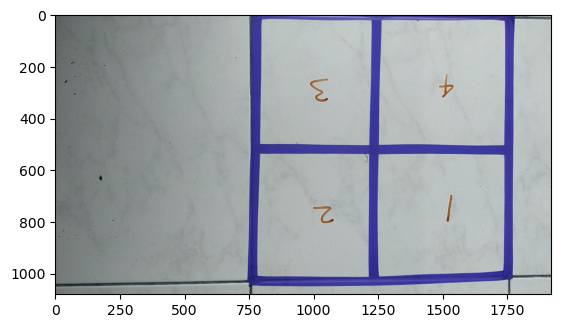

In [3]:
video_path = '../AI Assignment video.mp4'
cap = cv2.VideoCapture(video_path)

cap.set(cv2.CAP_PROP_POS_FRAMES, 30)
r, image = cap.read()

plt.imshow(image)

* From above reference the quardents are

In [4]:
quardent = {
    1: [1247, 537, 495, 477],
    2: [781, 537, 437, 479],
    3: [791, 15, 464, 493],
    4: [1251, 11, 494, 498]
}

# Function for detect balls for given frame  

In [5]:
def detect_balls(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    color_ranges = {
        'white': ([10, 10, 230], [40, 50, 255]),
        'orange': ([5, 130, 100], [6, 255, 255]),
        'green': ([85, 0, 60], [100, 255, 120]),
        'yellow': ([20, 100, 100], [40, 255, 255])
    }

    detected_balls = []
    
    # Process each color
    for color_name, (lower_color, upper_color) in color_ranges.items():
        mask = cv2.inRange(hsv, np.array(lower_color), np.array(upper_color))
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Process each contour
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 500: 
                x, y, w, h = cv2.boundingRect(contour)
                
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    detected_balls.append((color_name, (cx, cy)))
                        
                    # Draw a circle around the ball
                    cv2.circle(image, (cx, cy), 70, (0, 0, 255), 5)  # Green circle
    
    return image, detected_balls

# Final code to detect the ball quardent and type (Entry, Exit)

In [6]:
output = []
output.append(['Time', 'Quardent', 'Ball Color', 'Type'])
ball_state = {
    "quardent": {
        'white': None,
        'orange': None,
        'green': None,
        'yellow': None
    },
    "time_stamp":{
        'white': None,
        'orange': None,
        'green': None,
        'yellow': None
    },
    "entry":{
        'white': False,
        'orange': False,
        'green': False,
        'yellow': False
    }
}

quardent = {
    1: [1247, 537, 495, 477],
    2: [781, 537, 437, 479],
    3: [791, 15, 464, 493],
    4: [1251, 11, 494, 498]
}

current_frame = 30

fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

while current_frame < total_frames:
    cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
    r, frame = cap.read()

    # To detect balls
    image, ball_color_cord = detect_balls(frame)

    for color, value in ball_color_cord:
        x = value[0]
        y = value[1]

        for i in quardent:
            X, Y, W, H = quardent.get(i)
            
            if (x>X and X+W>x and y>Y and Y+H>y): # if ball inside quardent range
                
                if ball_state['quardent'][color] is None:
                    
                    # Check that ball remain in same quardent for next frame of time if yes then set quardent value and time
                    cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame+30)
                    r, frame = cap.read()
                    image, ball_color_cord = detect_balls(frame)

                    for item in ball_color_cord:
                        if item[0] == color:
                            x = item[1][0]
                            y = item[1][1]
                            for j in quardent:
                                X, Y, W, H = quardent.get(j)
                                if (x>X and X+W>x and y>Y and Y+H>y):
                                    if i == j:                 
                                        ball_state['quardent'][color] = i
                                        ball_state['time_stamp'][color] = current_frame/fps
                                        
                elif ball_state['quardent'][color] == i: # ball remain in same quardent mean entry type so update output file
                    if ball_state['entry'][color] is False:
                        # add to output
#                         print("entry", end="      ")
#                         print(color, i, ball_state['time_stamp'][color])
                        
                        output.append([ball_state['time_stamp'][color], i, color, "Entry"])
                        
                        ball_state['entry'][color] = True
                    else:
                        pass
                    
                else: # ball in different quardent then before mean exit type for confirm check entry field True mean entry already done
                    if ball_state['entry'][color] is True:
                        ball_state['quardent'][color] = None
                        ball_state['time_stamp'][color] = None
                        ball_state['entry'][color] = False
                        # add to output
#                         print("exit", end="      ")
#                         print(color, i, current_frame/fps)
                        
                        output.append([current_frame/fps, i, color, "Exit"])
     
    # Ball with entry true but not detect in frame mean very fast exit of ball
    colors_to_check = ['white', 'orange', 'green', 'yellow']

    for color in colors_to_check:
        found = False
        for item in ball_color_cord:
            if item[0] == color:
                found = True
                break
        if not found:
            if (ball_state['quardent'][color] is not None and ball_state['entry'][color] == True):
                # add to output
#                 print("fast_exit", end="      ")
#                 print(color, ball_state['quardent'][color], current_frame/fps)
                output.append([current_frame/fps, i, color, "Exit"])
                
                ball_state['quardent'][color] = None
                ball_state['time_stamp'][color] = None
                ball_state['entry'][color] = False
                
    current_frame += 30 # Update current frame 30 because fps = 30 hence check for each second
    
print("Processing Complete ----- Check the Output")

Processing Complete ----- Check the Output


In [7]:
import pandas as pd
df = pd.DataFrame(output[1:], columns=output[0])
df

,Time,Quardent,Ball Color,Type
0,2.0,3,yellow,Entry
1,10.0,2,white,Entry
2,10.0,4,green,Entry
3,13.0,1,orange,Entry
4,16.0,4,white,Exit
5,19.0,4,green,Exit
6,21.0,4,orange,Exit
7,25.0,4,white,Entry
8,27.0,2,orange,Entry
9,30.0,4,yellow,Exit


In [8]:
with open(r'output.txt', 'w') as fp:
    for item in output:
        fp.write("%s\n" % item)
    print('Done')

Done
